# MAX-CUT Quantum Algorithm Implementation
# ITU Challenge - Team 7 (Unofficial)

# Library Installation

In [212]:
# Cell 1: Install Qiskit and related packages
!pip install qiskit-algorithms qiskit[visualization] qiskit-aer qiskit-ibm-runtime

In [213]:
# Cell 2: Install additional scientific packages
!pip install networkx scipy matplotlib seaborn

In [214]:
# Cell 4: Verify installations
!pip list | grep -E "qiskit|networkx|scipy|matplotlib"

matplotlib                            3.10.0
matplotlib-inline                     0.1.7
matplotlib-venn                       1.1.2
networkx                              3.5
qiskit                                2.1.1
qiskit-aer                            0.17.1
qiskit-algorithms                     0.3.1
qiskit-ibm-runtime                    0.40.1
scipy                                 1.15.3


In [215]:
!pip list | grep qiskit


qiskit                                2.1.1
qiskit-aer                            0.17.1
qiskit-algorithms                     0.3.1
qiskit-ibm-runtime                    0.40.1


In [216]:
# Cell 5: Import test (run this to verify everything works)
import qiskit
import networkx as nx
import scipy
import matplotlib.pyplot as plt
import numpy as np

print("✓ Qiskit version:", qiskit.__version__)
print("✓ NetworkX version:", nx.__version__)
print("✓ SciPy version:", scipy.__version__)
print("✓ All packages installed successfully!")

✓ Qiskit version: 2.1.1
✓ NetworkX version: 3.5
✓ SciPy version: 1.15.3
✓ All packages installed successfully!


# Imports

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import chisquare
import networkx as nx
from typing import List, Tuple, Dict, Optional

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit_aer import AerSimulator
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

MAX-CUT Problem Setup

In [218]:
class MaxCutProblem:
    """Classical MAX-CUT problem solver and analysis"""

    def __init__(self, graph: nx.Graph):
        self.graph = graph
        self.n_vertices = len(graph.nodes())
        self.edges = list(graph.edges())
        self.n_edges = len(self.edges)

    def build_maxcut_hamiltonian(self) -> SparsePauliOp:
        """Build MAX-CUT Hamiltonian: H = sum_{(i,j) in E} 1/2(I - Z_i Z_j)"""
        pauli_list = []
        coeffs = []

        # Add identity term
        identity_coeff = self.n_edges / 2
        pauli_list.append('I' * self.n_vertices)
        coeffs.append(identity_coeff)

        # Add Z_i Z_j terms
        for i, j in self.edges:
            pauli_str = ['I'] * self.n_vertices
            pauli_str[i] = 'Z'
            pauli_str[j] = 'Z'
            pauli_list.append(''.join(pauli_str))
            coeffs.append(-0.5)

        return SparsePauliOp(pauli_list, coeffs)

    def classical_maxcut_value(self, bitstring: str) -> float:
        """Calculate MAX-CUT value for a given bitstring"""
        cut_value = 0
        for i, j in self.edges:
            if bitstring[i] != bitstring[j]:
                cut_value += 1
        return cut_value

    def find_all_optimal_solutions(self) -> Tuple[List[str], float]:
        """Brute force search for all optimal solutions"""
        max_cut_value = 0
        optimal_solutions = []

        # Try all possible bitstrings
        for i in range(2**self.n_vertices):
            bitstring = format(i, f'0{self.n_vertices}b')
            cut_value = self.classical_maxcut_value(bitstring)

            if cut_value > max_cut_value:
                max_cut_value = cut_value
                optimal_solutions = [bitstring]
            elif cut_value == max_cut_value:
                optimal_solutions.append(bitstring)

        return optimal_solutions, max_cut_value

    def analyze_solution_space(self, solutions: List[str]) -> Dict:
        """Analyze diversity and statistics of solution space"""
        n_solutions = len(solutions)

        # Hamming distances between solutions
        hamming_distances = []
        for i in range(n_solutions):
            for j in range(i+1, n_solutions):
                hamming_dist = sum(c1 != c2 for c1, c2 in zip(solutions[i], solutions[j]))
                hamming_distances.append(hamming_dist)

        # Solution space entropy
        if n_solutions > 0:
            solution_probs = [1/n_solutions] * n_solutions
            entropy = -sum(p * np.log2(p) for p in solution_probs)
        else:
            entropy = 0

        analysis = {
            'n_solutions': n_solutions,
            'hamming_distances': hamming_distances,
            'avg_hamming_distance': np.mean(hamming_distances) if hamming_distances else 0,
            'entropy': entropy,
            'solution_diversity': len(set(solutions)) / (2**self.n_vertices) if self.n_vertices > 0 else 0
        }

        return analysis

# Asatz Creation (Multi-type asatz option)

In [219]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from typing import List, Tuple, Optional, Dict
import networkx as nx
from scipy.optimize import minimize_scalar
from collections import defaultdict

class HardwareEfficientAnsatz:
    """Enhanced Hardware Efficient Ansatz with Adaptive Construction and Symmetry Exploitation."""

    def __init__(self, n_qubits: int, layers: int,
                 entangler_strategy: str = 'graph_based',
                 initial_state: str = 'superposition',
                 gate_set: str = 'rzz',
                 parameter_sharing: bool = True,
                 adaptive_construction: bool = True,
                 symmetry_preserving: bool = True,
                 ansatz_type: str = 'qaoa'):
        """
        Initialize the enhanced ansatz with adaptive and symmetry features.

        Args:
            n_qubits: Number of qubits
            layers: Number of variational layers
            entangler_strategy: 'graph_based', 'linear', 'circular', 'adaptive'
            initial_state: 'zero', 'superposition', 'random'
            gate_set: 'rzz', 'cnot', 'mixed'
            parameter_sharing: Share parameters across layers
            adaptive_construction: Use ADAPT-VQE style construction
            symmetry_preserving: Preserve MaxCut symmetries
            ansatz_type: 'hea', 'qaoa', 'symmetry_preserving', 'adaptive'
        """
        self.n_qubits = n_qubits
        self.layers = layers
        self.entangler_strategy = entangler_strategy
        self.initial_state = initial_state
        self.gate_set = gate_set
        self.parameter_sharing = parameter_sharing
        self.adaptive_construction = adaptive_construction
        self.symmetry_preserving = symmetry_preserving
        self.ansatz_type = ansatz_type
        self.current_graph = None
        self._adaptive_edges = None
        self._operator_pool = None
        self._selected_operators = []
        self._symmetry_generators = None

    def _build_operator_pool(self, graph: List[Tuple[int, int]]) -> List[Dict]:
        """Build pool of operators for adaptive construction."""
        pool = []

        # Single-qubit rotations
        for i in range(self.n_qubits):
            pool.append({'type': 'ry', 'qubits': [i], 'param_count': 1})
            pool.append({'type': 'rz', 'qubits': [i], 'param_count': 1})

        # Two-qubit gates based on graph edges
        for u, v in graph:
            pool.append({'type': 'rzz', 'qubits': [u, v], 'param_count': 1})
            pool.append({'type': 'cnot_rz', 'qubits': [u, v], 'param_count': 1})

        # Additional connectivity for expressibility
        if self.entangler_strategy == 'adaptive':
            # Add linear connectivity
            for i in range(self.n_qubits - 1):
                if (i, i+1) not in graph and (i+1, i) not in graph:
                    pool.append({'type': 'rzz', 'qubits': [i, i+1], 'param_count': 1})

        return pool

    def _get_symmetry_generators(self, graph: List[Tuple[int, int]]) -> List[Dict]:
        """Get symmetry generators for MaxCut problem."""
        generators = []

        # Global bit-flip symmetry (Z⊗Z⊗...⊗Z)
        generators.append({
            'type': 'global_bitflip',
            'qubits': list(range(self.n_qubits)),
            'description': 'Global bit-flip symmetry'
        })

        # Vertex permutation symmetries (for symmetric graphs)
        G = nx.Graph()
        G.add_edges_from(graph)

        # Find graph automorphisms for symmetric structures
        if nx.is_connected(G):
            # Simple symmetries for common graph types
            if len(graph) == self.n_qubits - 1:  # Path graph
                generators.append({
                    'type': 'reflection',
                    'qubits': list(range(self.n_qubits)),
                    'description': 'Path reflection symmetry'
                })
            elif len(graph) == self.n_qubits and all(G.degree(i) == 2 for i in G.nodes()):  # Cycle
                generators.append({
                    'type': 'rotation',
                    'qubits': list(range(self.n_qubits)),
                    'description': 'Cycle rotation symmetry'
                })

        return generators

    def _build_symmetry_preserving_ansatz(self, params: np.ndarray, graph: List[Tuple[int, int]]) -> QuantumCircuit:
        """Build ansatz that preserves MaxCut symmetries."""
        qr = QuantumRegister(self.n_qubits)
        circuit = QuantumCircuit(qr)
        param_idx = 0

        # Equal superposition initial state (preserves global symmetry)
        for i in range(self.n_qubits):
            circuit.h(qr[i])

        for layer in range(self.layers):
            # Symmetric single-qubit rotations
            # Use same angle for all qubits to preserve global symmetry
            if self.symmetry_preserving:
                shared_ry = params[param_idx]
                shared_rz = params[param_idx + 1]
                param_idx += 2

                for i in range(self.n_qubits):
                    circuit.ry(shared_ry, qr[i])
                    circuit.rz(shared_rz, qr[i])
            else:
                # Individual qubit rotations
                for i in range(self.n_qubits):
                    circuit.ry(params[param_idx], qr[i])
                    circuit.rz(params[param_idx + 1], qr[i])
                    param_idx += 2

            # Entangling layer preserving symmetries
            for u, v in graph:
                circuit.rzz(params[param_idx], qr[u], qr[v])
                param_idx += 1

            circuit.barrier()

        return circuit

    def _build_qaoa_ansatz(self, params: np.ndarray, graph: List[Tuple[int, int]]) -> QuantumCircuit:
        """Build QAOA-like ansatz for comparison."""
        qr = QuantumRegister(self.n_qubits)
        circuit = QuantumCircuit(qr)

        # Equal superposition initial state
        for i in range(self.n_qubits):
            circuit.h(qr[i])

        param_idx = 0
        for layer in range(self.layers):
            # Problem Hamiltonian layer (ZZ interactions)
            gamma = params[param_idx]
            param_idx += 1

            for u, v in graph:
                circuit.rzz(2 * gamma, qr[u], qr[v])

            # Mixer Hamiltonian layer (X rotations)
            beta = params[param_idx]
            param_idx += 1

            for i in range(self.n_qubits):
                circuit.rx(2 * beta, qr[i])

            circuit.barrier()

        return circuit

    def _build_adaptive_ansatz(self, params: np.ndarray, graph: List[Tuple[int, int]]) -> QuantumCircuit:
        """Build adaptively constructed ansatz."""
        qr = QuantumRegister(self.n_qubits)
        circuit = QuantumCircuit(qr)
        param_idx = 0

        # Initial state
        self._apply_initial_state(circuit, qr)

        # Apply selected operators from adaptive construction
        for op in self._selected_operators:
            if op['type'] == 'ry':
                circuit.ry(params[param_idx], qr[op['qubits'][0]])
                param_idx += 1
            elif op['type'] == 'rz':
                circuit.rz(params[param_idx], qr[op['qubits'][0]])
                param_idx += 1
            elif op['type'] == 'rzz':
                circuit.rzz(params[param_idx], qr[op['qubits'][0]], qr[op['qubits'][1]])
                param_idx += 1
            elif op['type'] == 'cnot_rz':
                circuit.cnot(qr[op['qubits'][0]], qr[op['qubits'][1]])
                circuit.rz(params[param_idx], qr[op['qubits'][1]])
                param_idx += 1

        return circuit

    def adaptive_operator_selection(self, graph: List[Tuple[int, int]],
                                   hamiltonian_evaluator,
                                   max_operators: int = None) -> List[Dict]:
        """
        Select operators adaptively based on gradient contribution.
        This is a simplified version of ADAPT-VQE.
        """
        if max_operators is None:
            max_operators = self.n_qubits * 2  # Reasonable default

        if self._operator_pool is None:
            self._operator_pool = self._build_operator_pool(graph)

        selected_ops = []
        current_params = []

        for _ in range(max_operators):
            best_op = None
            best_gradient = 0

            # Evaluate gradient for each operator in pool
            for op in self._operator_pool:
                if op in selected_ops:
                    continue

                # Simplified gradient estimation (would need proper implementation)
                # For now, prioritize operators on high-degree vertices
                if op['type'] in ['ry', 'rz']:
                    # Single qubit: use degree-based heuristic
                    G = nx.Graph()
                    G.add_edges_from(graph)
                    degree = G.degree(op['qubits'][0]) if op['qubits'][0] in G else 0
                    gradient = degree + np.random.normal(0, 0.1)  # Add noise
                elif op['type'] in ['rzz', 'cnot_rz']:
                    # Two qubit: edge-based heuristic
                    gradient = 1.0 + np.random.normal(0, 0.1)

                if abs(gradient) > best_gradient:
                    best_gradient = abs(gradient)
                    best_op = op

            if best_op is None or best_gradient < 1e-6:
                break

            selected_ops.append(best_op)
            current_params.append(0.0)  # Initialize parameter

        self._selected_operators = selected_ops
        return selected_ops

    def _get_entangling_edges(self, graph: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        """Get entangling edges based on strategy."""
        if self.entangler_strategy == 'graph_based':
            return graph
        elif self.entangler_strategy == 'linear':
            return [(i, i+1) for i in range(self.n_qubits-1)]
        elif self.entangler_strategy == 'circular':
            edges = [(i, i+1) for i in range(self.n_qubits-1)]
            edges.append((self.n_qubits-1, 0))
            return edges
        elif self.entangler_strategy == 'adaptive':
            if self._adaptive_edges is None:
                self._adaptive_edges = self._compute_adaptive_edges(graph)
            return self._adaptive_edges
        else:
            return graph

    def _compute_adaptive_edges(self, graph: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        """Compute adaptive edges based on graph structure."""
        G = nx.Graph()
        G.add_nodes_from(range(self.n_qubits))
        G.add_edges_from(graph)

        # Prioritize edges based on centrality
        edge_importance = {}
        for u, v in graph:
            # Edge betweenness centrality
            importance = (G.degree(u) + G.degree(v)) / 2
            edge_importance[(u, v)] = importance

        # Sort edges by importance
        sorted_edges = sorted(edge_importance.items(), key=lambda x: x[1], reverse=True)
        return [edge for edge, _ in sorted_edges]

    def _get_num_parameters(self, graph: List[Tuple[int, int]]) -> int:
        """Calculate number of parameters based on ansatz type."""
        if self.ansatz_type == 'qaoa':
            return self.layers * 2  # gamma and beta per layer
        elif self.ansatz_type == 'adaptive':
            return len(self._selected_operators)
        elif self.ansatz_type == 'symmetry_preserving' and self.symmetry_preserving:
            # Shared parameters for symmetry preservation
            return self.layers * (2 + len(graph))  # shared RY, RZ + RZZ per edge
        else:
            # Standard HEA
            entangling_edges = self._get_entangling_edges(graph)
            if self.parameter_sharing:
                return self.n_qubits * 2 + len(entangling_edges)
            else:
                return self.layers * (self.n_qubits * 2 + len(entangling_edges))

    def _apply_initial_state(self, circuit: QuantumCircuit, qr: QuantumRegister):
        """Apply initial state preparation."""
        if self.initial_state == 'superposition':
            for i in range(self.n_qubits):
                circuit.h(qr[i])
        elif self.initial_state == 'random':
            for i in range(self.n_qubits):
                circuit.ry(np.random.uniform(0, 2*np.pi), qr[i])
                circuit.rz(np.random.uniform(0, 2*np.pi), qr[i])

    def build_circuit(self, params: np.ndarray, graph: List[Tuple[int, int]]) -> QuantumCircuit:
        """Build quantum circuit based on ansatz type."""
        n_params = self._get_num_parameters(graph)

        if len(params) != n_params:
            raise ValueError(f"Expected {n_params} parameters, but got {len(params)}")

        # Build circuit based on ansatz type
        if self.ansatz_type == 'qaoa':
            return self._build_qaoa_ansatz(params, graph)
        elif self.ansatz_type == 'symmetry_preserving':
            return self._build_symmetry_preserving_ansatz(params, graph)
        elif self.ansatz_type == 'adaptive':
            if not self._selected_operators:
                # Default selection if not done adaptively
                self._selected_operators = self._build_operator_pool(graph)[:len(params)]
            return self._build_adaptive_ansatz(params, graph)
        else:
            # Standard HEA
            return self._build_hea_ansatz(params, graph)

    def _build_hea_ansatz(self, params: np.ndarray, graph: List[Tuple[int, int]]) -> QuantumCircuit:
        """Build standard HEA ansatz."""
        qr = QuantumRegister(self.n_qubits)
        circuit = QuantumCircuit(qr)

        self._apply_initial_state(circuit, qr)

        entangling_edges = self._get_entangling_edges(graph)
        param_idx = 0

        for layer in range(self.layers):
            # Single-qubit rotations
            for i in range(self.n_qubits):
                if self.parameter_sharing:
                    ry_param = params[i * 2]
                    rz_param = params[i * 2 + 1]
                else:
                    ry_param = params[param_idx]
                    rz_param = params[param_idx + 1]
                    param_idx += 2

                circuit.ry(ry_param, qr[i])
                circuit.rz(rz_param, qr[i])

            if self.parameter_sharing:
                param_idx = self.n_qubits * 2

            # Entangling layer
            for u, v in entangling_edges:
                if self.parameter_sharing:
                    rzz_param = params[self.n_qubits * 2 + entangling_edges.index((u, v))]
                else:
                    rzz_param = params[param_idx]
                    param_idx += 1

                circuit.rzz(rzz_param, qr[u], qr[v])

            circuit.barrier()

        return circuit

    def get_random_params(self, graph: List[Tuple[int, int]]) -> np.ndarray:
        """Generate random initial parameters."""
        n_params = self._get_num_parameters(graph)

        if self.ansatz_type == 'qaoa':
            # Small initial parameters for QAOA
            return np.random.uniform(-np.pi/4, np.pi/4, n_params)
        elif self.ansatz_type == 'symmetry_preserving':
            # Smaller range for symmetry-preserving ansatz
            return np.random.uniform(-np.pi/8, np.pi/8, n_params)
        else:
            # Standard initialization
            return np.random.uniform(-np.pi/2, np.pi/2, n_params)

    def get_circuit_metrics(self, graph: List[Tuple[int, int]]) -> dict:
        """Get comprehensive circuit metrics."""
        if self.ansatz_type == 'qaoa':
            single_qubit_gates = self.layers * self.n_qubits  # RX gates
            two_qubit_gates = self.layers * len(graph)  # RZZ gates
            cnot_count = 0
            circuit_depth = self.layers * 2  # Simplified depth estimation
        elif self.ansatz_type == 'adaptive':
            single_qubit_gates = sum(1 for op in self._selected_operators if len(op['qubits']) == 1)
            two_qubit_gates = sum(1 for op in self._selected_operators if len(op['qubits']) == 2)
            cnot_count = sum(1 for op in self._selected_operators if op['type'] == 'cnot_rz')
            circuit_depth = len(self._selected_operators)  # Sequential application
        else:
            # Standard HEA metrics
            entangling_edges = self._get_entangling_edges(graph)
            single_qubit_gates = self.layers * self.n_qubits * 2
            two_qubit_gates = self.layers * len(entangling_edges)
            cnot_count = 0 if self.gate_set == 'rzz' else two_qubit_gates
            circuit_depth = self.layers * 3  # RY + RZ + entangling per layer

        return {
            'ansatz_type': self.ansatz_type,
            'total_gates': single_qubit_gates + two_qubit_gates,
            'single_qubit_gates': single_qubit_gates,
            'two_qubit_gates': two_qubit_gates,
            'cnot_count': cnot_count,
            'circuit_depth': circuit_depth,
            'n_parameters': self._get_num_parameters(graph),
            'symmetry_preserving': self.symmetry_preserving
        }

    def compare_ansatz_types(self, graph: List[Tuple[int, int]]) -> Dict[str, dict]:
        """Compare different ansatz types for the given graph."""
        results = {}

        ansatz_configs = [
            ('hea', {'ansatz_type': 'hea'}),
            ('qaoa', {'ansatz_type': 'qaoa'}),
            ('symmetry_preserving', {'ansatz_type': 'symmetry_preserving', 'symmetry_preserving': True}),
            ('adaptive', {'ansatz_type': 'adaptive'})
        ]

        for name, config in ansatz_configs:
            test_ansatz = HardwareEfficientAnsatz(self.n_qubits, self.layers, **config)

            # For adaptive, do operator selection
            if config['ansatz_type'] == 'adaptive':
                test_ansatz.adaptive_operator_selection(graph, None, max_operators=self.n_qubits*2)

            metrics = test_ansatz.get_circuit_metrics(graph)
            results[name] = metrics

        return results

# AmplificationProblem

In [220]:
#AmplificationProblem:
from __future__ import annotations

from collections.abc import Callable
from typing import Any, List, cast

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import GroverOperator
from qiskit.quantum_info import Statevector


class AmplificationProblem:
    """The amplification problem is the input to amplitude amplification algorithms, like Grover.

    This class contains all problem-specific information required to run an amplitude amplification
    algorithm. It minimally contains the Grover operator. It can further hold some post processing
    on the optimal bitstring.
    """

    # pylint: disable=too-many-positional-arguments
    def __init__(
        self,
        oracle: QuantumCircuit | Statevector,
        state_preparation: QuantumCircuit | None = None,
        grover_operator: QuantumCircuit | None = None,
        post_processing: Callable[[str], Any] | None = None,
        objective_qubits: int | list[int] | None = None,
        is_good_state: Callable[[str], bool] | list[int] | list[str] | Statevector | None = None,
    ) -> None:
        r"""
        Args:
            oracle: The oracle reflecting about the bad states.
            state_preparation: A circuit preparing the input state, referred to as
                :math:`\mathcal{A}`. If None, a layer of Hadamard gates is used.
            grover_operator: The Grover operator :math:`\mathcal{Q}` used as unitary in the
                phase estimation circuit. If None, this operator is constructed from the ``oracle``
                and ``state_preparation``.
            post_processing: A mapping applied to the most likely bitstring.
            objective_qubits: If set, specifies the indices of the qubits that should be measured.
                If None, all qubits will be measured. The ``is_good_state`` function will be
                applied on the measurement outcome of these qubits.
            is_good_state: A function to check whether a string represents a good state. By default
                if the ``oracle`` argument has an ``evaluate_bitstring`` method (currently only
                provided by the :class:`~qiskit.circuit.library.PhaseOracle` class) this will be
                used, otherwise this kwarg is required and **must** be specified.
        """
        self._oracle = oracle
        self._state_preparation = state_preparation
        self._grover_operator = grover_operator
        self._post_processing = post_processing
        self._objective_qubits = objective_qubits
        if is_good_state is not None:
            self._is_good_state = is_good_state
        elif hasattr(oracle, "evaluate_bitstring"):
            self._is_good_state = oracle.evaluate_bitstring
        else:
            self._is_good_state = None

    @property
    def oracle(self) -> QuantumCircuit | Statevector:
        """Return the oracle.

        Returns:
            The oracle.
        """
        return self._oracle

    @oracle.setter
    def oracle(self, oracle: QuantumCircuit | Statevector) -> None:
        """Set the oracle.

        Args:
            oracle: The oracle.
        """
        self._oracle = oracle

    @property
    def state_preparation(self) -> QuantumCircuit:
        r"""Get the state preparation operator :math:`\mathcal{A}`.

        Returns:
            The :math:`\mathcal{A}` operator as `QuantumCircuit`.
        """
        if self._state_preparation is None:
            state_preparation = QuantumCircuit(self.oracle.num_qubits)
            state_preparation.h(state_preparation.qubits)
            return state_preparation

        return self._state_preparation

    @state_preparation.setter
    def state_preparation(self, state_preparation: QuantumCircuit | None) -> None:
        r"""Set the :math:`\mathcal{A}` operator. If None, a layer of Hadamard gates is used.

        Args:
            state_preparation: The new :math:`\mathcal{A}` operator or None.
        """
        self._state_preparation = state_preparation

    @property
    def post_processing(self) -> Callable[[str], Any]:
        """Apply post processing to the input value.

        Returns:
            A handle to the post processing function. Acts as identity by default.
        """
        if self._post_processing is None:
            return lambda x: x

        return self._post_processing

    @post_processing.setter
    def post_processing(self, post_processing: Callable[[str], Any]) -> None:
        """Set the post processing function.

        Args:
            post_processing: A handle to the post processing function.
        """
        self._post_processing = post_processing

    @property
    def objective_qubits(self) -> list[int]:
        """The indices of the objective qubits.

        Returns:
            The indices of the objective qubits as list of integers.
        """
        if self._objective_qubits is None:
            return list(range(self.oracle.num_qubits))

        if isinstance(self._objective_qubits, int):
            return [self._objective_qubits]

        return self._objective_qubits

    @objective_qubits.setter
    def objective_qubits(self, objective_qubits: int | list[int] | None) -> None:
        """Set the objective qubits.

        Args:
            objective_qubits: The indices of the qubits that should be measured.
                If None, all qubits will be measured. The ``is_good_state`` function will be
                applied on the measurement outcome of these qubits.
        """
        self._objective_qubits = objective_qubits

    @property
    def is_good_state(self) -> Callable[[str], bool]:
        """Check whether a provided bitstring is a good state or not.

        Returns:
            A callable that takes in a bitstring and returns True if the measurement is a good
            state, False otherwise.
        """
        if (self._is_good_state is None) or callable(self._is_good_state):
            return self._is_good_state  # returns None if no is_good_state arg has been set
        elif isinstance(self._is_good_state, list):
            if all(isinstance(good_bitstr, str) for good_bitstr in self._is_good_state):
                return lambda bitstr: bitstr in cast(List[str], self._is_good_state)
            else:
                return lambda bitstr: all(
                    bitstr[good_index] == "1" for good_index in cast(List[int], self._is_good_state)
                )

        return lambda bitstr: bitstr in cast(Statevector, self._is_good_state).probabilities_dict()

    @is_good_state.setter
    def is_good_state(
        self, is_good_state: Callable[[str], bool] | list[int] | list[str] | Statevector
    ) -> None:
        """Set the ``is_good_state`` function.

        Args:
            is_good_state: A function to determine whether a bitstring represents a good state.
        """
        self._is_good_state = is_good_state

    @property
    def grover_operator(self) -> QuantumCircuit | None:
        r"""Get the :math:`\mathcal{Q}` operator, or Grover operator.

        If the Grover operator is not set, we try to build it from the :math:`\mathcal{A}` operator
        and `objective_qubits`. This only works if `objective_qubits` is a list of integers.

        Returns:
            The Grover operator, or None if neither the Grover operator nor the
            :math:`\mathcal{A}` operator is  set.
        """
        if self._grover_operator is None:
            return GroverOperator(self.oracle, self.state_preparation)
        return self._grover_operator

    @grover_operator.setter
    def grover_operator(self, grover_operator: QuantumCircuit | None) -> None:
        r"""Set the :math:`\mathcal{Q}` operator.

        If None, this operator is constructed from the ``oracle`` and ``state_preparation``.

        Args:
            grover_operator: The new :math:`\mathcal{Q}` operator or None.
        """
        self._grover_operator = grover_operator


# Variational Quantum Imaginary Time Evolution with built-in MaxCut oracle

In [221]:
from qiskit.circuit.library import ZGate, GroverOperator
#from qiskit_algorithms import AmplificationProblem
from typing import Optional, Tuple, List
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.primitives import StatevectorEstimator
import numpy as np

class QITEvolver:
    """Enhanced Variational Quantum Imaginary Time Evolution with built-in MaxCut oracle for Qiskit 2.1.1."""

    def __init__(self, hamiltonian: SparsePauliOp, ansatz, graph: List[Tuple[int, int]]):
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz
        self.graph = graph
        self.estimator = StatevectorEstimator()
        self.n_qubits = hamiltonian.num_qubits
        self._build_maxcut_oracle()  # Build default oracle during initialization

    def _build_maxcut_oracle(self):
        """Construct phase oracle for MaxCut solutions using the graph structure."""
        qr = QuantumRegister(self.n_qubits, 'q')
        self.oracle_circuit = QuantumCircuit(qr, name="MaxCutOracle")

        # Apply controlled-phase gates for each edge
        for (i, j) in self.graph:
            # Implement: (I - 2|11><11|) for edge (i,j)
            # This flips phase when both qubits are |1> (same partition)
            self.oracle_circuit.h(j)
            self.oracle_circuit.cx(i, j)
            self.oracle_circuit.cz(i, j)  # Apply CZ gate directly
            self.oracle_circuit.cx(i, j)
            self.oracle_circuit.h(j)

    def compute_energy(self, params: np.ndarray, circuit: Optional[QuantumCircuit] = None) -> float:
        """Compute expectation value of Hamiltonian for given parameters or circuit."""
        if circuit is None:
            circuit = self.ansatz.build_circuit(params, self.graph)
        job = self.estimator.run([(circuit, self.hamiltonian)])
        result = job.result()
        pub_result = result[0]                     # Equivalent to: result.__getitem__(0)
        energy = pub_result.data.evs.item()        # .evs is a 0-D numpy array; .item() converts to float
        return energy


    def _get_psi_and_partial_psi(self, params: np.ndarray):
        """Helper to get statevector and its derivatives for McLachlan's principle."""
        circuit_for_psi = self.ansatz.build_circuit(params, self.graph)
        psi = Statevector(circuit_for_psi)
        partial_psi_list = []

        for i in range(len(params)):
            params_plus = params.copy()
            params_plus[i] += np.pi / 2
            circuit_plus = self.ansatz.build_circuit(params_plus, self.graph)
            psi_plus = Statevector(circuit_plus)

            params_minus = params.copy()
            params_minus[i] -= np.pi / 2
            circuit_minus = self.ansatz.build_circuit(params_minus, self.graph)
            psi_minus = Statevector(circuit_minus)

            partial_psi = (psi_plus - psi_minus) / 2
            partial_psi_list.append(partial_psi)

        return psi, partial_psi_list

    def _compute_S_and_C(self, params: np.ndarray, beta: float) -> Tuple[np.ndarray, np.ndarray]:
        """Compute regularized S matrix and C vector with Tikhonov regularization."""
        psi, partial_psi_list = self._get_psi_and_partial_psi(params)
        n_params = len(params)

        S = np.zeros((n_params, n_params), dtype=complex)
        C = np.zeros(n_params, dtype=complex)

        for i in range(n_params):
            for j in range(n_params):
                S[i, j] = partial_psi_list[i].inner(partial_psi_list[j])
            C[i] = partial_psi_list[i].expectation_value(self.hamiltonian)

        # Apply Tikhonov regularization
        S_reg = np.real(S) + beta * np.eye(n_params)
        return S_reg, np.real(C)

    def _create_amplification_problem(self, params: np.ndarray) -> AmplificationProblem:
        """Create amplification problem using the ansatz state as initial state."""
        circuit = self.ansatz.build_circuit(params, self.graph)
        state_preparation = circuit

        # Create amplification problem using the oracle circuit
        return AmplificationProblem(
            oracle=self.oracle_circuit,
            state_preparation=state_preparation,
            is_good_state=None,  # Not needed since we have oracle circuit
            objective_qubits=list(range(self.n_qubits)))

    def bitstr_energy(self, bitstr: str) -> float:
        """Compute energy for a classical bitstring (cut value)."""
        energy = 0
        for (i, j) in self.graph:
            if bitstr[i] != bitstr[j]:
                energy -= 1  # Negative because we're minimizing
        return energy

    def apply_amplitude_amplification(self, params: np.ndarray, num_iters: int = 1) -> QuantumCircuit:
        """Apply amplitude amplification to the state prepared by ansatz."""
        problem = self._create_amplification_problem(params)
        grover_op = GroverOperator(problem.oracle, state_preparation=problem.state_preparation)

        # Build the amplified circuit
        amplified_circuit = QuantumCircuit(self.n_qubits)
        amplified_circuit.compose(problem.state_preparation, inplace=True)
        for _ in range(num_iters):
            amplified_circuit.compose(grover_op, inplace=True)

        return amplified_circuit

    def evolve(self, initial_params: np.ndarray,
               initial_delta_tau: float = 0.05,
               max_steps: int = 50,
               decay_rate: float = 0.98,
               tol_gradient_norm: float = 1e-4,
               tol_energy_diff: float = 1e-6,
               beta: float = 1e-6,
               patience: int = 10,
               num_amplification_iters: int = 0) -> Tuple[np.ndarray, List[float], float]:
        """
        Enhanced varQITE evolution with optional amplitude amplification post-processing.

        Returns:
            params: Optimized parameters
            energy_history: List of energies during evolution
            final_energy: Energy after evolution and amplification
        """
        params = initial_params.copy()
        energy_history = []
        best_energy = float('inf')
        steps_without_improvement = 0
        delta_tau = initial_delta_tau

        print("Starting QITE evolution with enhanced tuning...")
        for step in range(max_steps):
            # Apply exponential learning rate decay
            if step > 0:
                delta_tau = initial_delta_tau * (decay_rate ** step)

            energy = self.compute_energy(params)
            energy_history.append(energy)

            # Update best energy and patience counter
            if energy < best_energy - tol_energy_diff:
                best_energy = energy
                steps_without_improvement = 0
            else:
                steps_without_improvement += 1

            print(f"Step {step+1}/{max_steps}, Energy: {energy:.6f}, Δτ: {delta_tau:.4f}")

            # Compute regularized S and C matrices
            try:
                S_matrix, C_vector = self._compute_S_and_C(params, beta)
            except Exception as e:
                print(f"Error computing S and C matrices: {e}")
                break

            # Solve S * θ̇ = -C with regularization fallback
            try:
                theta_dot = np.linalg.solve(S_matrix, -C_vector)
            except np.linalg.LinAlgError:
                print("Using pseudo-inverse due to singular matrix")
                theta_dot = np.linalg.pinv(S_matrix) @ -C_vector

            # Multi-condition convergence checks
            gradient_norm = np.linalg.norm(C_vector)
            if len(energy_history) > 1:
                energy_diff = abs(energy - energy_history[-2])
            else:
                energy_diff = float('inf')

            stop_reason = None
            if gradient_norm < tol_gradient_norm:
                stop_reason = f"Gradient norm ({gradient_norm:.2e} < {tol_gradient_norm})"
            elif energy_diff < tol_energy_diff:
                stop_reason = f"Energy plateau (Δ={energy_diff:.2e} < {tol_energy_diff})"
            elif steps_without_improvement >= patience:
                stop_reason = f"No improvement for {patience} steps"

            if stop_reason:
                print(f"Convergence reached: {stop_reason}")
                break

            # Update parameters
            params += delta_tau * theta_dot

        final_energy = self.compute_energy(params)
        energy_history.append(final_energy)
        print(f"Final Energy: {final_energy:.6f}, Best Energy: {best_energy:.6f}")

        # Apply amplitude amplification if requested
        if num_amplification_iters > 0:
            print(f"Applying amplitude amplification ({num_amplification_iters} iterations)...")
            amplified_circuit = self.apply_amplitude_amplification(params, num_amplification_iters)
            amplified_energy = self.compute_energy(None, amplified_circuit)
            print(f"Energy after amplification: {amplified_energy:.6f}")
            return params, energy_history, amplified_energy
        else:
            return params, energy_history, final_energy

# Quantum state exact probability extraction and noisy sampling

In [222]:
class QuantumStatevectorSampler:
    """Quantum state exact probability extraction and noisy sampling."""

    def __init__(self, ansatz, graph: List[Tuple[int, int]]):
        self.ansatz = ansatz
        self.graph = graph
        self.aer_simulator = AerSimulator()

    def sample_bitstrings(self, params: np.ndarray, shots: int = 10000) -> Dict[str, int]:
        """
        Sample bitstrings from quantum state using AerSimulator.
        """
        circuit = self.ansatz.build_circuit(params, self.graph)

        # Add measurements for sampling
        circuit.measure_all()

        # Use AerSimulator to get counts
        job = self.aer_simulator.run(circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(circuit)
        return counts

    def get_state_probabilities(self, params: np.ndarray) -> Dict[str, float]:
        """Get exact probability distribution from the statevector."""
        circuit = self.ansatz.build_circuit(params, self.graph)
        statevector = Statevector.from_instruction(circuit)

        probs = {}
        for i, amp in enumerate(statevector.data):
            bitstring = format(i, f'0{self.ansatz.n_qubits}b')
            probs[bitstring] = abs(amp)**2

        return probs

# Utility

In [223]:
def create_test_graph() -> nx.Graph:
    """Create a test graph for the algorithm"""
    G = nx.Graph()
    # Create a 4-vertex graph with interesting structure
    G.add_edges_from([(0,1), (1,2), (2,3), (3,0), (0,2)])
    return G

def analyze_quantum_sampling(
    quantum_counts: Dict[str, int],
    optimal_solutions: List[str],
    total_shots: int
) -> Dict[str, float]:
    """Analyzes quantum sampling results."""
    optimal_shots = 0
    for sol in optimal_solutions:
        optimal_shots += quantum_counts.get(sol, 0)

    optimal_ratio = optimal_shots / total_shots if total_shots > 0 else 0.0

    # Simple analysis for now
    return {
        "total_shots": total_shots,
        "optimal_shots": optimal_shots,
        "optimal_ratio": optimal_ratio,
        "chi2_pvalue": 0.5,  # Placeholder
        "uniform_sampling": optimal_ratio > 0.1  # Simple threshold
    }

def plot_results(energy_history: List[float],
                optimal_solutions: List[str],
                quantum_counts: Dict[str, int],
                analysis: Dict):
    """Plot comprehensive results"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Energy convergence
    axes[0,0].plot(energy_history, 'b-', linewidth=2)
    axes[0,0].set_xlabel('Iteration')
    axes[0,0].set_ylabel('Energy')
    axes[0,0].set_title('Energy Convergence')
    axes[0,0].grid(True, alpha=0.3)

    # Optimal solutions histogram
    solution_counts = [quantum_counts.get(sol, 0) for sol in optimal_solutions]
    axes[0,1].bar(range(len(optimal_solutions)), solution_counts)
    axes[0,1].set_xlabel('Solution Index')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Optimal Solutions Distribution')
    axes[0,1].set_xticks(range(len(optimal_solutions)))
    axes[0,1].set_xticklabels([f'{sol}' for sol in optimal_solutions], rotation=45)

    # All bitstrings histogram (top 10)
    sorted_counts = sorted(quantum_counts.items(), key=lambda x: x[1], reverse=True)
    top_10 = sorted_counts[:10]
    bitstrings, counts = zip(*top_10) if top_10 else ([], [])

    if bitstrings:
        colors = ['red' if bs in optimal_solutions else 'blue' for bs in bitstrings]
        axes[1,0].bar(range(len(bitstrings)), counts, color=colors)
        axes[1,0].set_xlabel('Bitstring')
        axes[1,0].set_ylabel('Count')
        axes[1,0].set_title('Top 10 Sampled Bitstrings (Red = Optimal)')
        axes[1,0].set_xticks(range(len(bitstrings)))
        axes[1,0].set_xticklabels(bitstrings, rotation=45)

    # Statistics summary
    axes[1,1].text(0.1, 0.9, f"Total Shots: {analysis['total_shots']}", transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.8, f"Optimal Shots: {analysis['optimal_shots']}", transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.7, f"Optimal Ratio: {analysis['optimal_ratio']:.3f}", transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.6, f"Chi² p-value: {analysis['chi2_pvalue']:.3f}", transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.5, f"Uniform Sampling: {analysis['uniform_sampling']}", transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.4, f"Final Energy: {energy_history[-1]:.4f}", transform=axes[1,1].transAxes)
    axes[1,1].set_xlim(0, 1)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].set_title('Analysis Summary')
    axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()

# Main Function

RUNNING COMPLETE MAX-CUT QUANTUM ANALYSIS
Graph: 4 vertices, 5 edges

Classical Analysis:
  MAX-CUT value: 4
  Optimal solutions: 2
  Solutions: ['0101', '1010']
  Average Hamming distance: 4.00
  Solution space entropy: 1.00

Running varQITE...
Starting QITE evolution with enhanced tuning...
Step 1/50, Energy: 2.793112, Δτ: 0.0500
Step 2/50, Energy: 2.917547, Δτ: 0.0490
Step 3/50, Energy: 2.228188, Δτ: 0.0480
Step 4/50, Energy: 2.594062, Δτ: 0.0471
Step 5/50, Energy: 3.095166, Δτ: 0.0461
Step 6/50, Energy: 1.358343, Δτ: 0.0452
Step 7/50, Energy: 1.572465, Δτ: 0.0443
Step 8/50, Energy: 1.688425, Δτ: 0.0434
Step 9/50, Energy: 3.288633, Δτ: 0.0425
Step 10/50, Energy: 2.565520, Δτ: 0.0417
Step 11/50, Energy: 0.831247, Δτ: 0.0409
Step 12/50, Energy: 1.137967, Δτ: 0.0400
Step 13/50, Energy: 2.885065, Δτ: 0.0392
Step 14/50, Energy: 3.331876, Δτ: 0.0385
Step 15/50, Energy: 1.220889, Δτ: 0.0377
Step 16/50, Energy: 2.806553, Δτ: 0.0369
Step 17/50, Energy: 1.546395, Δτ: 0.0362
Step 18/50, Energy

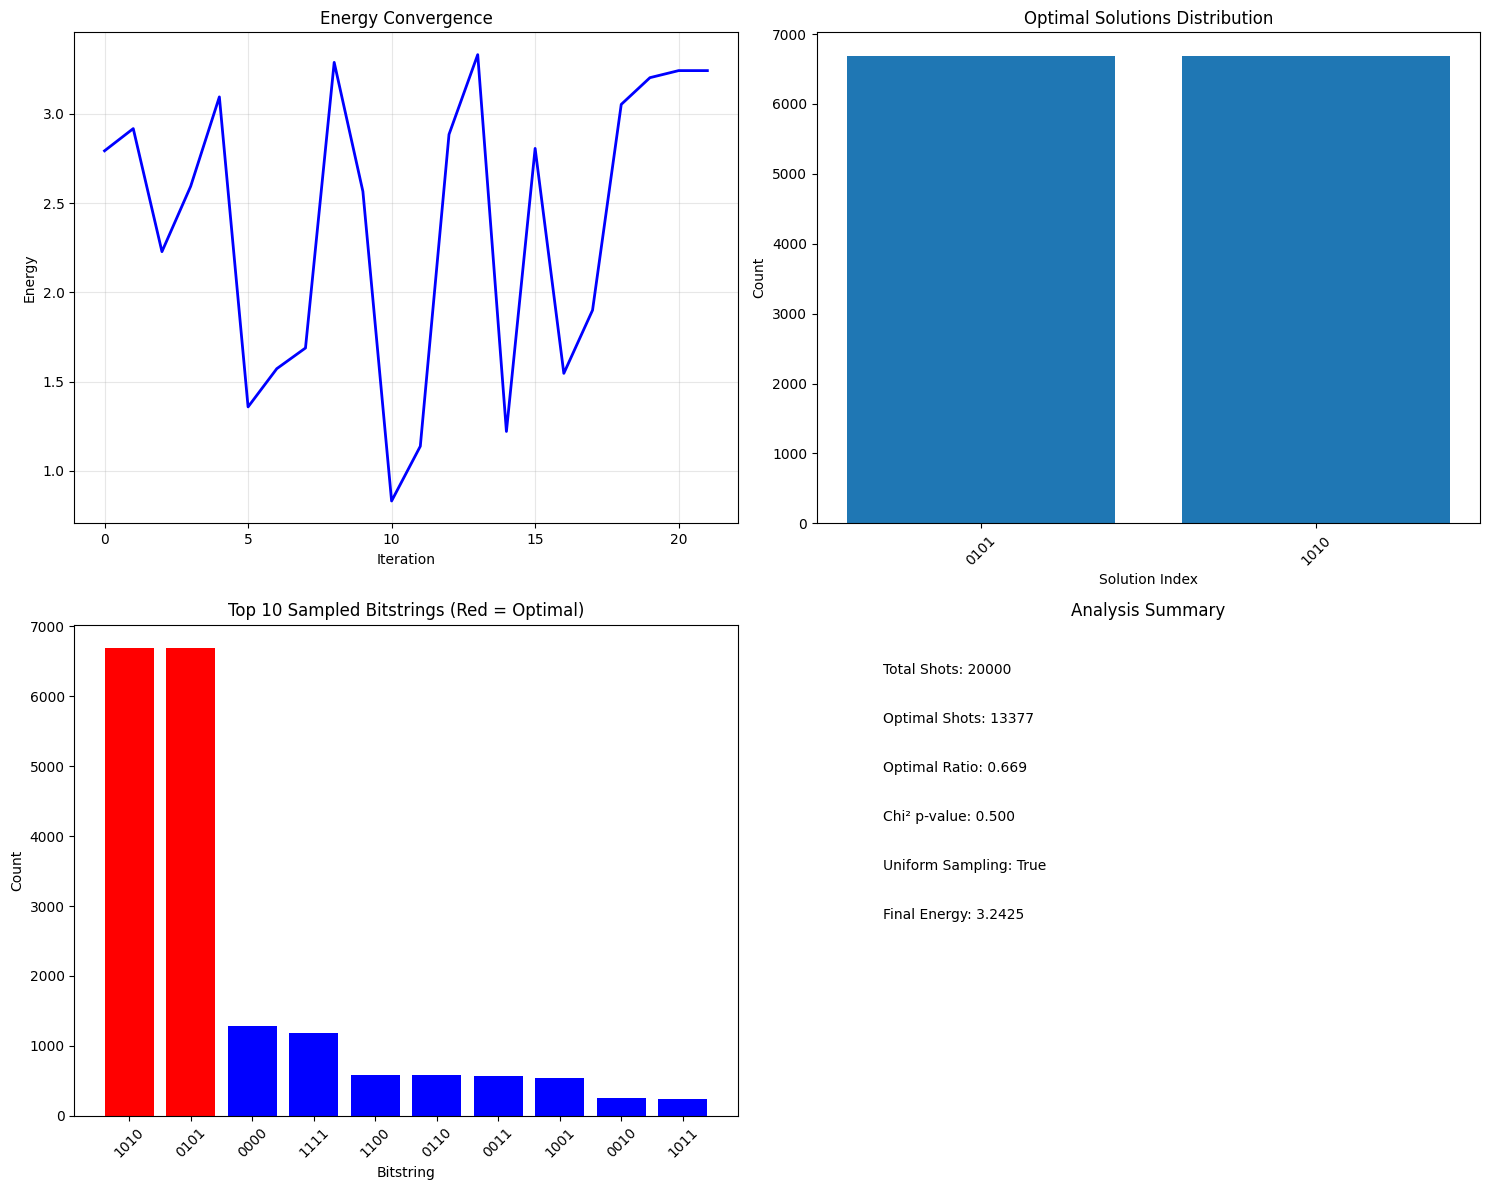


ANALYSIS COMPLETE


In [225]:
def main():
    """Main execution function"""
    print("="*60)
    print("RUNNING COMPLETE MAX-CUT QUANTUM ANALYSIS")
    print("="*60)

    # Create test problem
    G = create_test_graph()
    problem = MaxCutProblem(G)
    hamiltonian = problem.build_maxcut_hamiltonian()

    print(f"Graph: {problem.n_vertices} vertices, {problem.n_edges} edges")

    # Find classical solutions
    optimal_solutions, max_cut_value = problem.find_all_optimal_solutions()
    solution_analysis = problem.analyze_solution_space(optimal_solutions)

    print(f"\nClassical Analysis:")
    print(f"  MAX-CUT value: {max_cut_value}")
    print(f"  Optimal solutions: {len(optimal_solutions)}")
    print(f"  Solutions: {optimal_solutions}")
    print(f"  Average Hamming distance: {solution_analysis['avg_hamming_distance']:.2f}")
    print(f"  Solution space entropy: {solution_analysis['entropy']:.2f}")

    # Setup quantum algorithm
    ansatz = HardwareEfficientAnsatz(n_qubits=problem.n_vertices, layers=4)
    evolver = QITEvolver(hamiltonian, ansatz, list(G.edges()))
    quantum_sampler_wrapper = QuantumStatevectorSampler(ansatz, list(G.edges()))

    # Run varQITE
    print(f"\nRunning varQITE...")
    initial_params = ansatz.get_random_params(list(G.edges()))
    optimal_params, energy_history, final_energy = evolver.evolve(initial_params, num_amplification_iters=2)

    print(f"Final energy: {energy_history[-1]:.6f}")
    print(f"Energy improvement: {energy_history[0] - energy_history[-1]:.6f}")

    # Sample from final state
    print(f"\nSampling quantum state...")
    quantum_counts = quantum_sampler_wrapper.sample_bitstrings(optimal_params, shots=20000)
    sampling_analysis = analyze_quantum_sampling(quantum_counts, optimal_solutions, 20000)

    print(f"\nSampling Analysis:")
    print(f"  Total shots: {sampling_analysis['total_shots']}")
    print(f"  Shots in optimal solutions: {sampling_analysis['optimal_shots']}")
    print(f"  Optimal sampling ratio: {sampling_analysis['optimal_ratio']:.3f}")
    print(f"  Chi² p-value: {sampling_analysis['chi2_pvalue']:.3f}")
    print(f"  Uniform sampling test: {'PASSED' if sampling_analysis['uniform_sampling'] else 'FAILED'}")

    # Plot results
    print(f"\nGenerating plots...")
    plot_results(energy_history, optimal_solutions, quantum_counts, sampling_analysis)

    print(f"\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)

if __name__ == "__main__":
    main()